In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.time_series import TSForecastingExperiment

### Load and preprocess data

In [ ]:
def loadAndPreprocessData(filePath):
    data = pd.read_csv(filePath)
    data['Date_Time'] = pd.to_datetime(data['Date_Time'])
    data = data.sort_values(by='Date_Time').reset_index(drop=True)
    
    data['Date'] = data['Date_Time'].dt.date
    dailyData = data.groupby('Date').agg({
        'Temperature_C': 'mean'
    }).reset_index()

    dailyData['Date'] = pd.to_datetime(dailyData['Date'])
    dailyData = dailyData.set_index('Date').asfreq('D')
    dailyData = dailyData.interpolate(method='time') 
    
    return dailyData

### Splitting the data into training & testing 

In [ ]:
def splitData(data, splitRatio=0.8):
    splitIndex = int(len(data) * splitRatio)
    trainData = data.iloc[:splitIndex].copy()
    testData = data.iloc[splitIndex:].copy()
    return trainData, testData

### Train pycaret ARIMA Model 

In [ ]:
def setupPycaretExperiment(trainData, targetColumn='Temperature_C'):
    exp = TSForecastingExperiment()
    exp.setup(
        data=trainData,
        target=targetColumn,
        numeric_imputation_target='mean',  
        session_id=123
    )
    return exp

In [ ]:
def trainArimaModel(exp):
    bestModel = exp.create_model('arima')  
    return bestModel

### Printing evaluation metrics

In [ ]:
def evaluateForecast(exp, model, forecastHorizon):
    forecast = exp.predict_model(model, fh=forecastHorizon)
    return forecast

### Plotting actual vs forecasted values

In [24]:
def plotForecastsVsActual(dates, actual, forecasted, modelName="ARIMA", temp_min=-19.97, temp_max=40.00):
    plt.figure(figsize=(10, 5))
    plt.plot(dates, actual, marker='o', linestyle='-', label='Actual')
    plt.plot(dates, forecasted, marker='o', linestyle='-', label='Forecasted')
    
    plt.axhline(y=temp_min, color='red', linestyle='--', linewidth=1, label=f'Min Temp: {temp_min:.2f}°C')
    plt.axhline(y=temp_max, color='green', linestyle='--', linewidth=1, label=f'Max Temp: {temp_max:.2f}°C')
    
    plt.title(f'Actual vs Forecasted using {modelName}')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
weatherData = loadAndPreprocessData('weather_data.csv')
trainData, testData = splitData(weatherData)
forecastHorizon = list(range(1, len(testData) + 1))

exp = setupPycaretExperiment(trainData)
arimaModel = trainArimaModel(exp)

forecast = evaluateForecast(exp, arimaModel, forecastHorizon)

,Description,Value
0,session_id,123
1,Target,Temperature_C
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(111, 1)"
5,Transformed data shape,"(111, 1)"
6,Transformed train set shape,"(110, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.0160,0.0131,0.0037,0.0037,0.0002,0.0002
1,2024-04-17,0.0131,0.0108,0.0030,0.0030,0.0002,0.0002
2,2024-04-18,0.1168,0.0960,0.0268,0.0268,0.0018,0.0018
Mean,NaT,0.0486,0.0400,0.0112,0.0112,0.0008,0.0008
SD,NaT,0.0482,0.0396,0.0111,0.0111,0.0007,0.0007


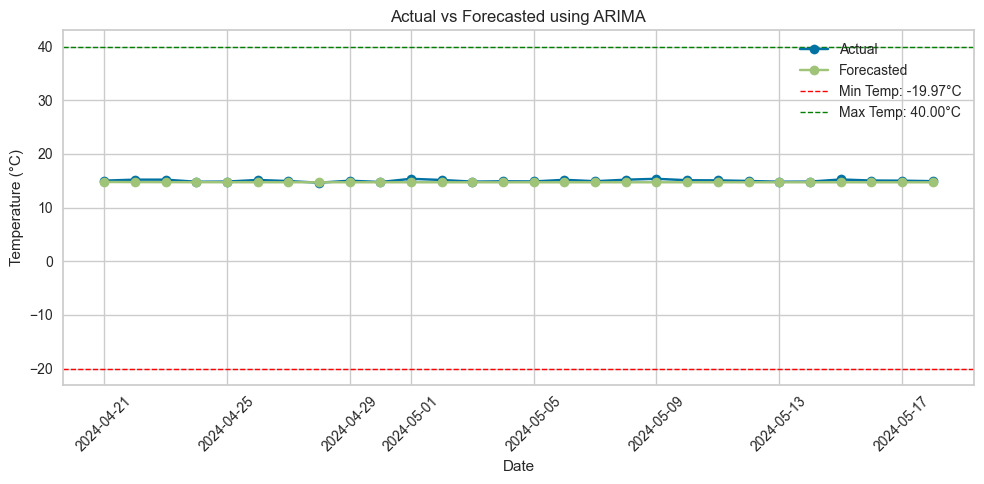

In [25]:
plotForecastsVsActual(testData.index, testData['Temperature_C'], forecast, "ARIMA")